# Avanced lane finding project

## Description

The different steps of used in this project are the following:
1. First we compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
1. Then, we apply the distortion correction to raw images.
1. We look for different color transforms, gradients, etc., and combine them to create a thresholded binary image.
1. We then apply a perspective transform to rectify binary image ("birds-eye view").
1. In that birds-eye view we look lane pixels using histogram and fit to find the lane boundary.
1. Then we determine the curvature of the lane and vehicle position with respect to center.
1. Finally we warp the detected lane boundaries back onto the original image.
1. We output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position. We save the outputs in the output_images folder.

## 0. Import all needed libraries

In [1]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib qt

### 0.1. Create global variables, helper classes and functions

In [2]:
# Make a list of calibration images
calib_images = glob.glob('camera_cal/calibration*.jpg')

# Make a list of test_images
test_images = glob.glob('test_images/*.jpg')

# function used for sliders
def f_slider(x):
    return x

def create_interactive_slider(function_slider, name, slider_range=(0,255)):
    slider = interactive(function_slider, x=slider_range)
    display(slider)
    slider.children[0].description = name
    return slider

# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None  

## 1.  Get distortion coefficients and camera matrix from camera calibration using chessboard

In [24]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

DISPLAY = False
# Step through the list and search for chessboard corners
for fname in calib_images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        if DISPLAY :
            img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)   
            cv2.imshow('img',img)
            cv2.waitKey(500)

cv2.destroyAllWindows()

use_refined_camera_matrix = False
# define a function that takes object points, and image points
# and performs the camera calibration
def camera_calibration(objpoints, imgpoints):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return mtx,dist

camera_matrix, dist_coeff = camera_calibration(objpoints, imgpoints)
print("camera_matrix is : \n", camera_matrix)
print("dist_coeff is : \n", dist_coeff)


camera_matrix is : 
 [[1.15777942e+03 0.00000000e+00 6.67111050e+02]
 [0.00000000e+00 1.15282305e+03 3.86129068e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
dist_coeff is : 
 [[-0.24688832 -0.02372817 -0.00109843  0.00035105 -0.00259133]]


## 2.  Apply distortion to raw images to get rectified images

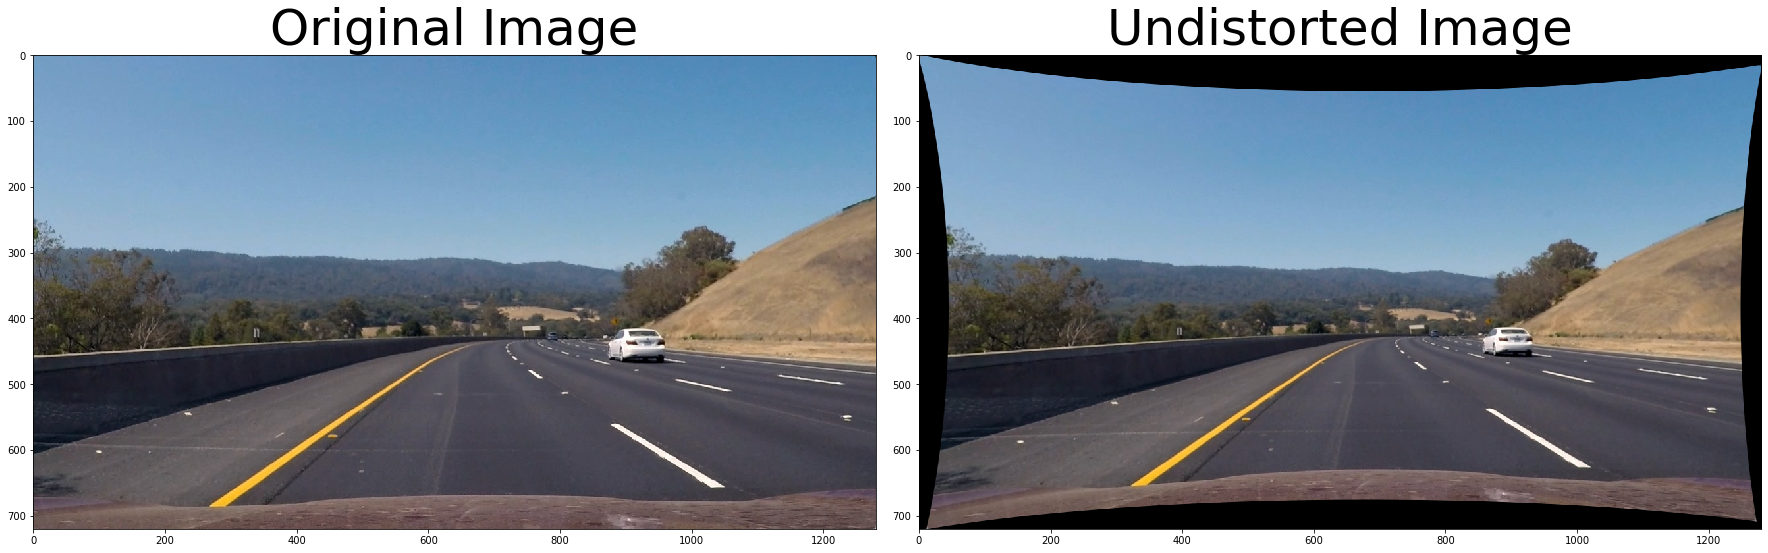

In [26]:
use_refined_camera_matrix = False
# define a function that takes an image, the camera_matrix and dist_coeff
# performs the image distortion correction and 
# returns the undistorted image
def cal_undistort(img, camera_matrix, dist_coeff):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # we use the cv2.getOptimalNewCameraMatrix() to refine the camera matrix 
    # and get the undistorted image with all pixels.
    if use_refined_camera_matrix:
        h,  w = img.shape[:2]
        newcameramtx, roi=cv2.getOptimalNewCameraMatrix(camera_matrix,dist_coeff,(w,h),1,(w,h))
        undist = cv2.undistort(img, camera_matrix, dist_coeff, None, newcameramtx)
    else :
        undist = cv2.undistort(img, camera_matrix, dist_coeff, None, camera_matrix)        
    return undist

# Make a list of undistorted images
undistorted_test_images = []

# print("test_images is :", test_images)
for test_image in test_images:
    img = cv2.imread(test_image)
    undistorted_img = cal_undistort(img, camera_matrix, dist_coeff)
    # let's save the result and append it to undistorted_test_images list
    image_name = test_image.split("/")[1].split(".")[0]+'_undistorted.png'
    cv2.imwrite('output_images/' + image_name, undistorted_img)
    undistorted_test_images.append(image_name)
#     cv2.imshow('undistorted_img',undistorted_img)
#     cv2.waitKey(500)
# cv2.destroyAllWindows()        

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
original_img = cv2.imread(test_images[2])
ax1.imshow(cv2.cvtColor(original_img, cv2.COLOR_RGB2BGR))
ax1.set_title('Original Image', fontsize=50)
undist_img = cv2.imread('output_images/' + undistorted_test_images[2])
ax2.imshow(cv2.cvtColor(undist_img, cv2.COLOR_RGB2BGR))
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## 3. Combine thresholds techniques to create binay image

In [7]:
H = create_interactive_slider(f_slider, "H")
L = create_interactive_slider(f_slider, "L")
S =  create_interactive_slider(f_slider, "S")
low_thresh = create_interactive_slider(f_slider, "low_thresh")
high_thresh = create_interactive_slider(f_slider,"high_thresh")
print(H.result)
print(L.result)
print(S.result)
print(low_thresh.result)
print(high_thresh.result)

interactive(children=(IntSlider(value=127, description='x', max=255), Output()), _dom_classes=('widget-interac…

interactive(children=(IntSlider(value=127, description='x', max=255), Output()), _dom_classes=('widget-interac…

interactive(children=(IntSlider(value=127, description='x', max=255), Output()), _dom_classes=('widget-interac…

interactive(children=(IntSlider(value=127, description='x', max=255), Output()), _dom_classes=('widget-interac…

interactive(children=(IntSlider(value=127, description='x', max=255), Output()), _dom_classes=('widget-interac…

127
127
127
127
127


## 4. Apply persperctive transform 

In [ ]:
img_size = (img.shape[1], img.shape[0])   
print("img_size is : ", img_size)
offset = 200 # offset for dst points

src = np.float32([imgpoints[0][0], imgpoints[0][nx-1], imgpoints[0][-1], imgpoints[0][-nx]])   
print("src is : ", src)

dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                             [img_size[0]-offset, img_size[1]-offset], 
                             [offset, img_size[1]-offset]])  
print("dst is : ", dst)

# use cv2.getPerspectiveTransform() to get M, the transform matrix
M = cv2.getPerspectiveTransform(src, dst)   
print ("Matrix transform is : \n", M)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
original_img = cv2.imread(test_images[0])
ax1.imshow(cv2.cvtColor(original_img, cv2.COLOR_RGB2BGR))
ax1.set_title('Original Image', fontsize=50)
undist_img = cv2.imread('output_images/' + undistorted_test_images[0])
ax2.imshow(cv2.cvtColor(undist_img, cv2.COLOR_RGB2BGR))
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

if M is not None:
    # Step through the list of undistorted_test_images to wrap them and get rectified_image
    for undistorted_img in undistorted_test_images:
        undistorted_img = cv2.imread('output_images/' + undistorted_img)

        # Grab the image shape
        img_size = (undistorted_img.shape[1], undistorted_img.shape[0])  

        # let's use the distortion_coeff
        warped = cv2.warpPerspective(undistorted_img, M, img_size, flags=cv2.INTER_LINEAR)

        # Draw and display the corners
        cv2.imshow('img',warped)
        cv2.waitKey()

    cv2.destroyAllWindows()
else :
    print("Something is wrong, Matrix transform is not defined !")


## 5. Detect lane pixels using Histogram and get lane boundary

## 6. Compute lane curvature and vehicle position to center

## 7. Warp the lane boundaries back onto the original image

## 8. Output and save final visual display with lane curvature and vehicle position on the image.